# DSC 340 Lab 0: Linear Regression Demo

Thomas E. Allen  
Instructor's solution  
DSC 340A S25  
Lab 0: Demo: Linear Regression 

## Overview

In this lab we will:

* review our skills from DSC 270, including writing code in plain Python and using various packages
* learn to fit the parameters of a OLS linear regression model using Python's sklearn toolkit
* learn to use Pandas to read data from a CSV file and store it as a Pandas DataFrame object
* introduce several toolkits in the Python universe including:
  * Jupyter
  * Pandas
  * Matplotlib
  * Seaborn
  * Scikit-learn
  * Markdown
* demonstrate how to apply the Data Analytics Lifecycle to solve a problem of practical interest.

For this assignment we will use the Medical Cost Personal Datasets, available on Kaggle and GitHub, to forecast payouts from insurance claims given information about the insured person. 

Dataset: https://www.kaggle.com/datasets/mirichoi0218/insurance


## Problem: Insurance Cost Prediction

Our goal in this project is to use the dataset to accurately predict insurance costs for our customers. By using predictive analytics, we can provide our customers with a better understanding of their health care costs, which will help them make informed decisions and save money. This can also help our company remain competitive in the market.

## Import Libraries

We need to import the necessary libraries before we can begin our analysis. Pandas is a powerful library for data analysis and manipulation. It is used to read data from a CSV file and store it as a Pandas DataFrame object. Numpy is a linear algebra library, and Matplotlib and Seaborn are data visualization libraries. We may want to experiment with sklearn's LabelEncoder and OneHotEncoder to convert categorical variables into numerical ones. Finally, we will use the LinearRegression class from sklearn to fit the parameters of our linear regression model and other methods to evaluate our model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Import the Dataset

Next, we import the CSV file. (Note: CSV stands for Comma Separated Values, which you used in your CS1 class.) We can use Pandas to import the dataset and represent it as a DataFrame. A DataFrame is a two-dimensional array-like structure in which each column is a variable and each row is an observation. Additionally, we can use Pandas to read a CSV file from a URL, and there is a similar method `read_excel()` for reading MS Excel files.


In [2]:
# Read the dataset
df = pd.read_csv('insurance.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv')

## Exploratory Data Analysis

Before any thought of model-building, it is important to explore the dataset. We can use Pandas to get some basic information about the dataset. Let's start by getting the column names, data types, and number of non-null values for each column. We will also get the shape of the dataset. This will give us an idea of the size and structure of the dataset and help us better understand it.

In [3]:
# Get the first five rows
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# Get column names, data types, and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### Observations

The features (independent variables) `age`, `bmi`, and `children` are already represented as numeric values, while `sex`, `smoker` and `region` are **categorical**. This is important since it affects how we will conduct the EDA. We will also have to decide how to handle the categorical data later when we prepare it for model-building.

Note that we could also use the `shape` and `columns` properties to obtain general information about the data.

In [5]:
# Get shape of the dataset
df.shape

(1338, 7)

The output of (1338, 7) means that the dataset has 1338 rows and 7 columns. 

In [6]:
# Get column names
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

### Summary statistics and missing values

To get a better understanding of the data, let's explore the summary statistics for continous variables (including the dependent variable that we want to predict). We will also output the values and counts for the discrete variables and check for any missing values.

In [7]:
# Get summary statistics
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [8]:
# Get the value counts for sex
print("Sex:")
print(df['sex'].value_counts())

# Get the value counts for smoker
print("\nSmoker:")
print(df['smoker'].value_counts())

# Get the value counts for region
print("\nRegion:")
print(df['region'].value_counts())

# Ratio of non-smokers to smokers:
print("Ratio of non-smokers to smokers:", 
      ((df['smoker'] == 'no').sum().astype(float) / 
       (df['smoker'] == 'yes').sum().astype(float)).round(2))

# What happens if you uncomment the following line? Can you explain the output?
# print(df[['sex', 'smoker', 'region']].value_counts())

Sex:
sex
male      676
female    662
Name: count, dtype: int64

Smoker:
smoker
no     1064
yes     274
Name: count, dtype: int64

Region:
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64
Ratio of non-smokers to smokers: 3.88


Observations:

* The discrete variable `sex` is composed of two values, `male` and `female`. 
  * The number of females and males in the dataset is relatively balanced.
  * We note that intersex persons do not seem to be included or have been mislabeled. 
* Variable `smoker` is a binary variable with values `yes` and `no`. 
  * We observe that there are about 4 times as many non-smokers as smokers in the dataset.
* `Region` consists of the values `southeast`, `southwest`, `northwest`, and `northeast`. 
  * We would need to look more closely at the original paper or other source to learn how these regions are defined.

In [9]:
# Check for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There do not seem to be any missing values. 

### Visualizing relationships among the variables

We now use various plots to visualize the relationships among the variables. 

#### Age and insurance charages

We begin with the relationship between age and insurance costs. 

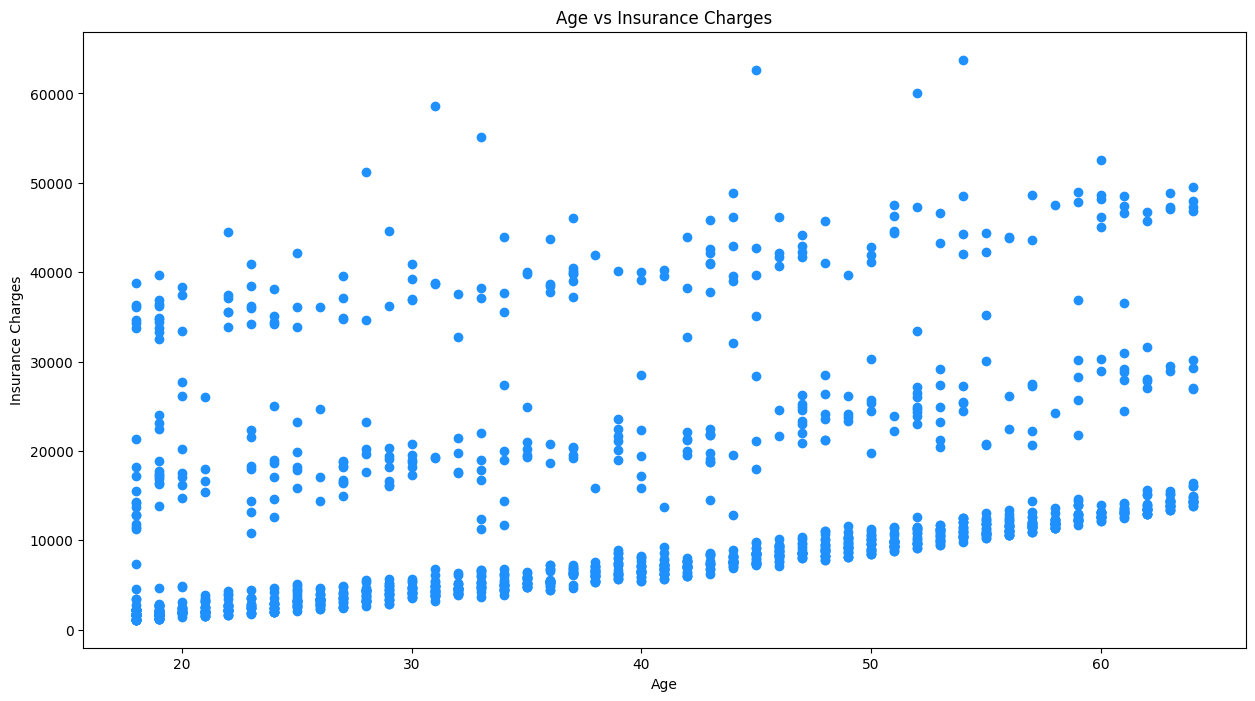

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(df.age, df.charges, color='dodgerblue')
plt.xlabel('Age')
plt.ylabel('Insurance Charges')
plt.title('Age vs Insurance Charges')
plt.show()

We observe what appear to be three "bands" in the plot. We hypothesize that these can be partially explained by discrete explanatory variables, such as sex or smoking status. To explore this, we will regenerate the plots with a legend differentiating the discrete variables.

#### Age, sex, and insurance charges

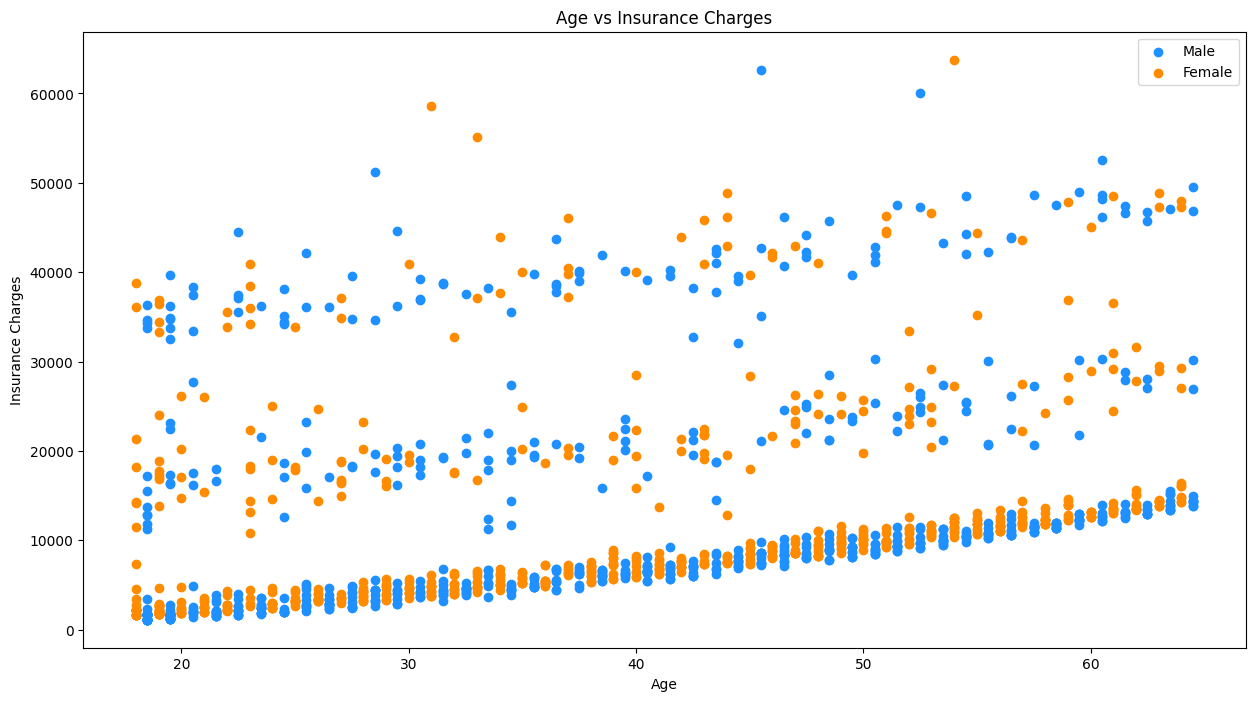

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(df.age[df.sex == 'male'] + 0.5, # add half a year so points don't overlap
            df.charges[df.sex == 'male'], 
            color='dodgerblue', label='Male')
plt.scatter(df.age[df.sex == 'female'], 
            df.charges[df.sex == 'female'], 
            color='darkorange', label='Female')
plt.xlabel('Age')
plt.ylabel('Insurance Charges')
plt.legend()
plt.title('Age vs Insurance Charges')
plt.show()

We cannot infer much about the relationship between sex and insurance payouts from this data visualization. Let's look at the effect of smoking.

#### Age, smoking status, and insurance charges

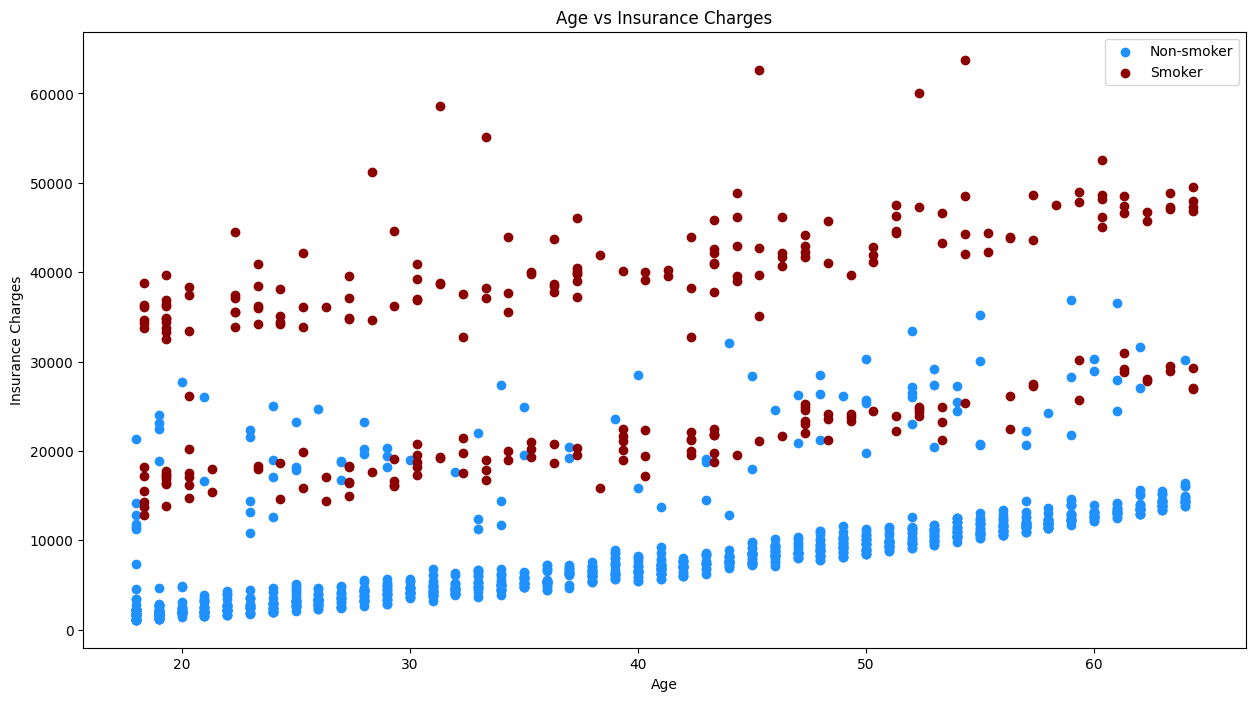

In [12]:
fig, ax = plt.subplots(figsize=(15,8))
# again, we shift one group over slightly
plt.scatter(df.age[df.smoker == 'no'], 
            df.charges[df.smoker == 'no'], 
            color='dodgerblue', label='Non-smoker')
plt.scatter(df.age[df.smoker == 'yes'] + 0.33, 
            df.charges[df.smoker == 'yes'], 
            color='darkred', label='Smoker')
plt.xlabel('Age')
plt.ylabel('Insurance Charges')
plt.legend()
plt.title('Age vs Insurance Charges')
plt.show()

The data visualization suggests that insurance payouts correlate with being a smoker as well as age. We will next look at the relationship between smoking, BMI, age, and insurance claims. 

#### Age, BMI, and Insurance Charges

**BMI** stands for **body mass index** and is a measure of a person's weight relative to their height. It is a useful metric for determining if someone is overweight or obese and can be used to calculate the risk of developing certain health conditions such as heart disease and diabetes. Higher BMI may indicate a higher risk of developing health problems, which could result in higher insurance premiums.

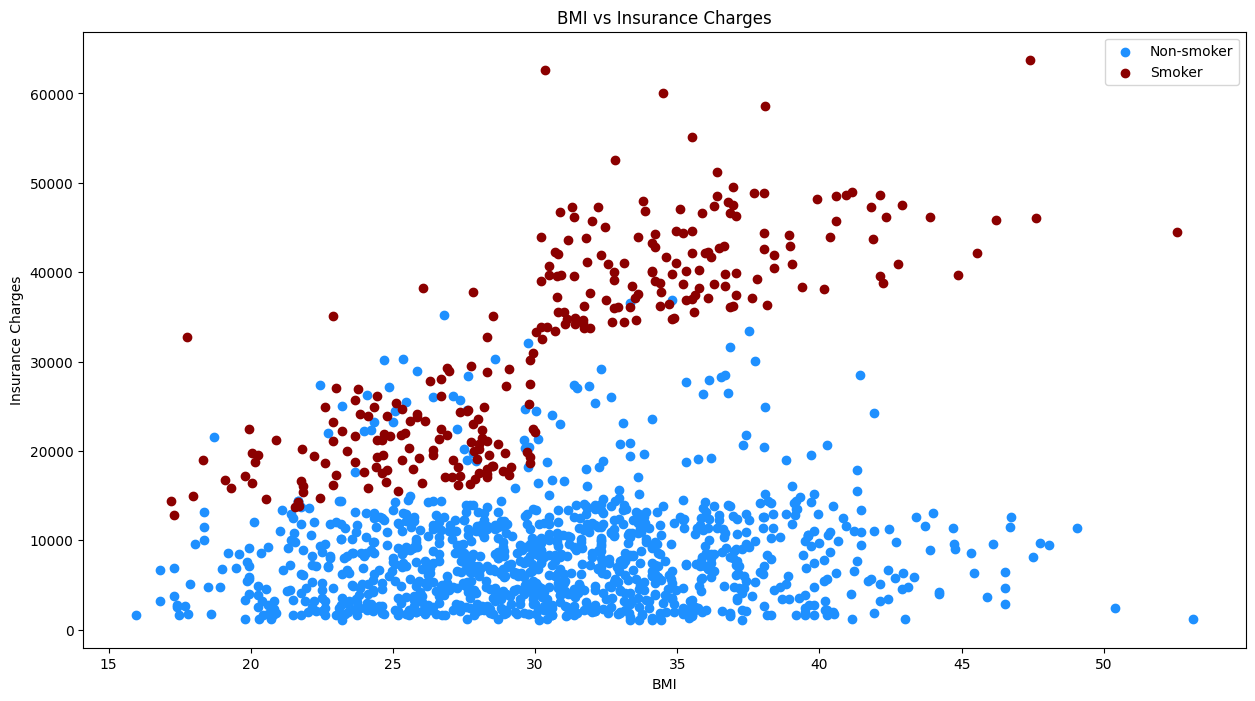

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(df.bmi[df.smoker == 'no'], 
            df.charges[df.smoker == 'no'], 
            color='dodgerblue', label="Non-smoker")
plt.scatter(df.bmi[df.smoker == 'yes'], 
            df.charges[df.smoker == 'yes'], 
            color='darkred', label="Smoker")
plt.xlabel('BMI')
plt.ylabel('Insurance Charges')
plt.legend()
plt.title('BMI vs Insurance Charges')
plt.show()

From the scatter plot, we notice what seems to be a significant relationship between BMI and insurance charges, especially for those who are also smokers.

#### Relative distributions for costs of smokers and non-smokers

To show the relative distributions for costs of smokers and non-smokers, we will use a violin plot.

Note: The region of the plot shows the relative density of the data across different categories. In this case, the categories are smokers and non-smokers. The violin plot shows the distribution of costs (y-axis) for each group (smokers and non-smokers). The width of each violin indicates the relative amount of data in each group, while the shape of the violin indicates the skewness of the data.

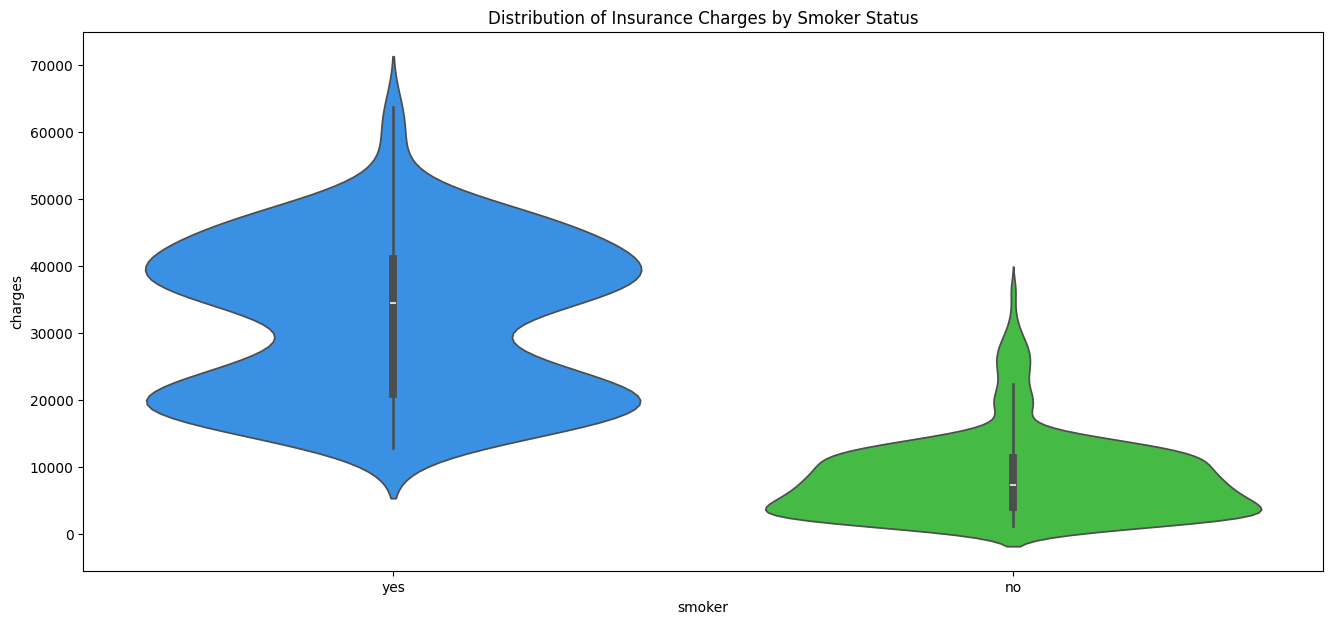

In [14]:
plt.figure(figsize=(16,7))
sns.violinplot(x="smoker", y="charges", hue="smoker", data=df, palette=['dodgerblue', 'limegreen'], legend=False)
plt.title('Distribution of Insurance Charges by Smoker Status')
plt.show()

#### Distributions of Insurance Charges by Sex

We use a similar plot to compare insurance costs by sex.

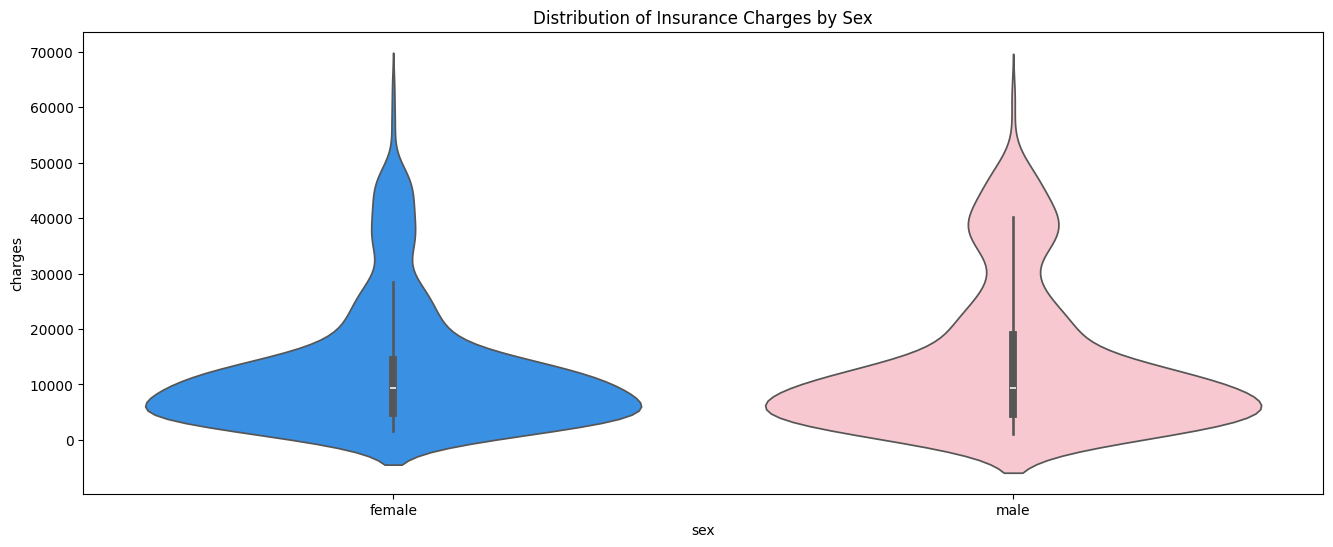

In [15]:
plt.figure(figsize=(16,6))
sns.violinplot(x="sex", y="charges", hue="sex", data=df, palette=['dodgerblue', 'pink'], legend=False)
plt.title('Distribution of Insurance Charges by Sex')
plt.show()

#### Distribution of Insurance Charges by Region

Here we show how the distribution of charges varies by region.

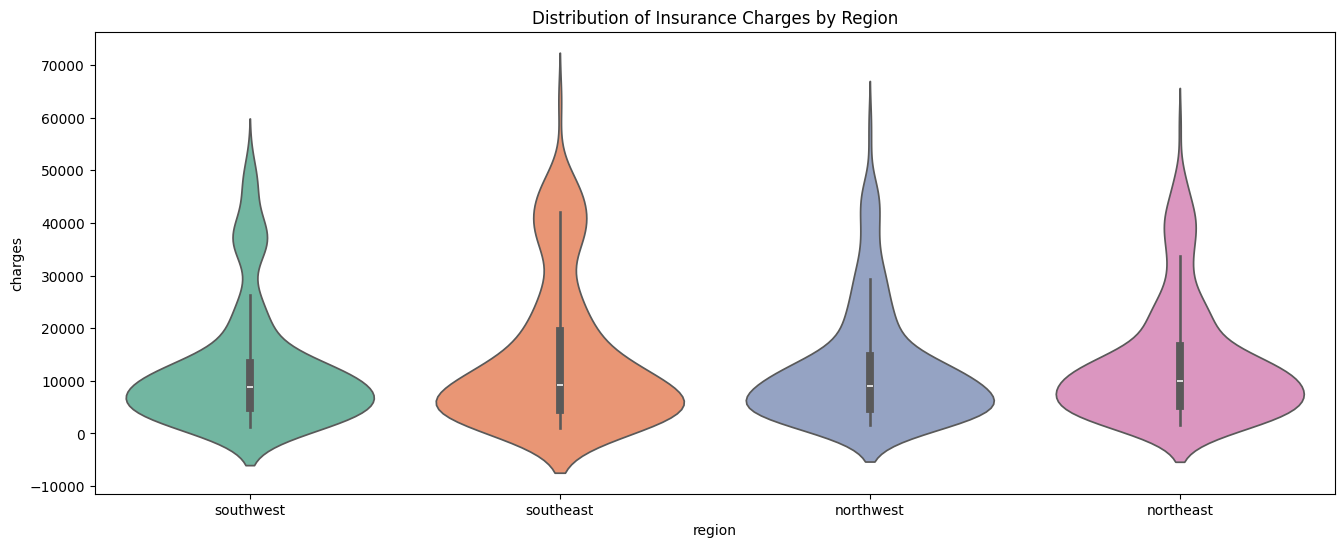

In [16]:
plt.figure(figsize=(16,6))
sns.violinplot(x="region", y="charges", data=df, hue="region", palette="Set2")
plt.title('Distribution of Insurance Charges by Region')
plt.show()

#### Distribution of Insurance Charges by Region and Sex

It is also possible to show relationships across more than two dimensions. Here we use a box plot to explore the relationship of costs to region and sex.

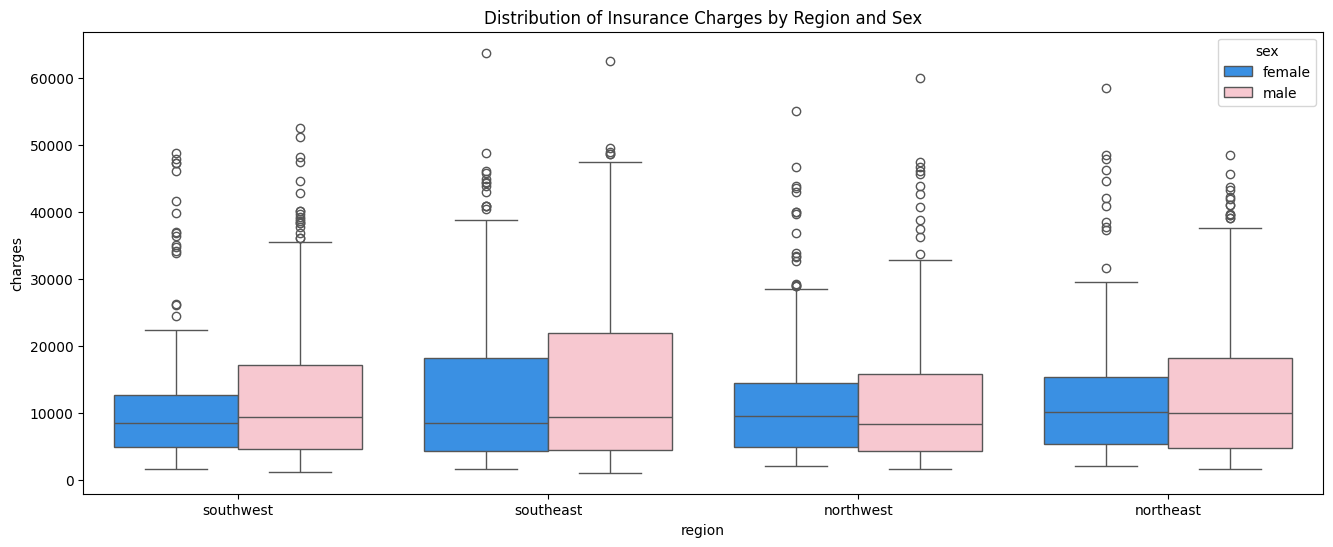

In [17]:
plt.figure(figsize=(16,6))
sns.boxplot(x="region", y="charges", hue="sex", data=df, palette=["dodgerblue", "pink"])
plt.title('Distribution of Insurance Charges by Region and Sex')
plt.show()

#### Distribution of Insurance Charges by Number of Children

Similarly, we look at the effect of the number of children on costs.

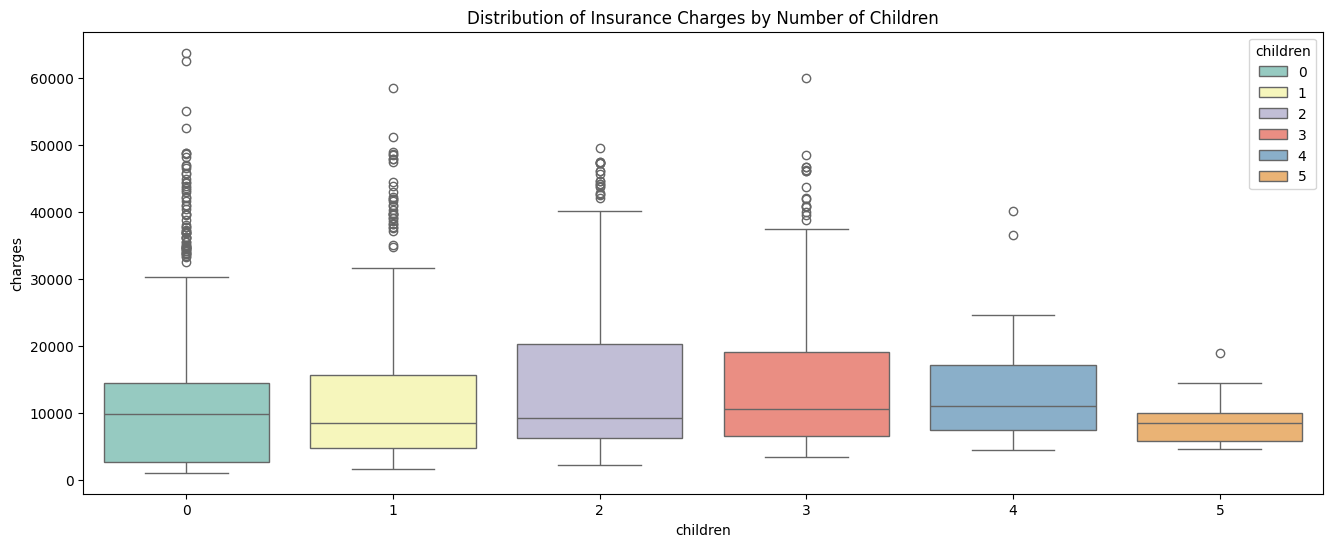

In [18]:
plt.figure(figsize=(16,6))
sns.boxplot(x="children", y="charges", data=df, hue="children", palette="Set3")
plt.title('Distribution of Insurance Charges by Number of Children')
plt.show()

#### Heat map showing correlation between continuous random variables

We use Seaborn to plot a heat map that shows the correlation between two continuous random variables.

The colors on the heat map represent the correlation between the two continuous random variables. Darker colors indicate a stronger correlation, while lighter colors indicate a weaker correlation. The correlation is calculated using Pearson's correlation coefficient and ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation).

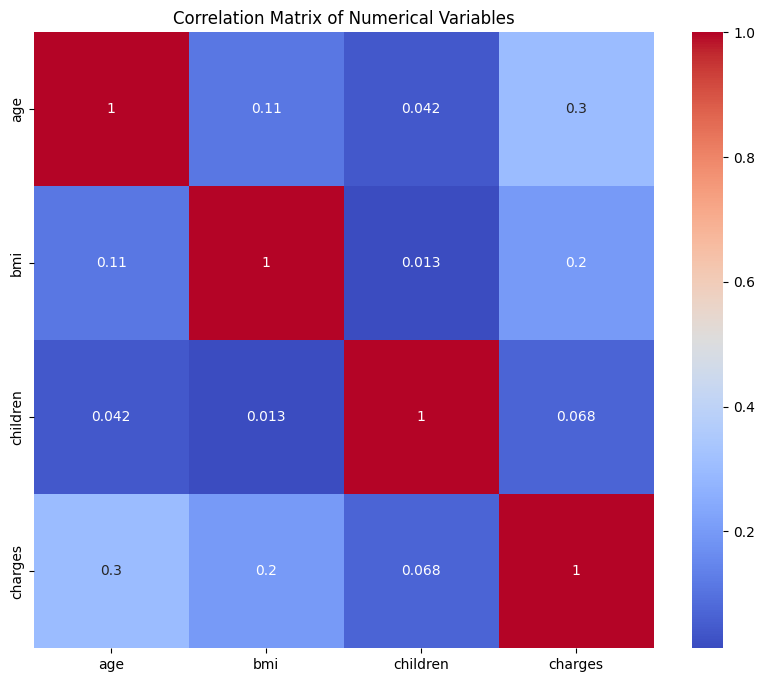

In [19]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

### Observations from EDA

We notice that costs seem to increase as the number of children the person has had increases, while noting that the sample size decreases as the number of children increases. The most significant variables from our exploratory data analysis seem to be age, smoking status, and BMI.

## Preparing the Data for Model Building

Before we can build a model, we need to make sure that the data is prepared correctly. This includes making sure that all the features are numerical and that they have been normalized or scaled appropriately. We can use various techniques, such as min-max scaling, standardization, or median imputation to prepare the data for model building. Once the data is ready, we can start to build the model.

### Encoding Categorical Variables

Recall that some of our data features are categorical, such as sex or smoker. We need to encode these variables into numerical values before we can build the model. We can use various techniques, such as one-hot encoding or label encoding, to encode these categorical variables.

Since `sex` takes on only two values, we just represent these as 0 and 1. (We call such variables **binary variables**.) Note that the assignent of 0 or 1 to a value is arbitrary. In some cases, such as with the values Yes and No, it may make sense to encode Yes as 1 and No as 0. In other cases, such as here, we can flip a coin to determine the assignment.

For **multi-valued categorical values**, such as `region`, **one-hot encoding** can be used, which involves creating a separate binary variable for each value, with a 1 indicating that the sample belongs to that category, and a 0 indicating otherwise. The new variables are often called *dummy variables*. However, since this term is problematic, your instructor prefers the term **indicator variables.**

Note that it is not necessary to encode all of the possible values, since the last value can be inferred from the other values. In fact, it is important that we **not** model all the values; doing so is sometimes known as the "dummy variable trap," and it is important to avoid it when building machine learning models. Doing so can lead to **multicollinearity**, which can lead to inaccurate predictions since it can cause the model to overfit the data. The method of one-hot encoding that we use here is formally known as 1-of-$(k-1)$ encoding.


In [20]:
# Encode the sex variable
labelencoder_sex = LabelEncoder()
df['sex'] = pd.to_numeric(df['sex'].map({'female': 0, 'male': 1}), errors='coerce').fillna(-1).astype(int)

# Here is another way for the smoker variable
df['smoker'] = (df['smoker'] == 'yes').astype(int)

# Encode the region variable
df['northeast'] = df['region'].apply(lambda x: 1 if x == 'northeast' else 0)
df['southeast'] = df['region'].apply(lambda x: 1 if x == 'southeast' else 0)
df['southwest'] = df['region'].apply(lambda x: 1 if x == 'southwest' else 0)
df.drop('region', axis=1, inplace=True)


We output the first few rows of our DataFrame to manually inspect the encoding.

In [21]:
df.head()

,age,sex,bmi,children,smoker,charges,northeast,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,0,0,0
4,32,1,28.880,0,0,3866.85520,0,0,0


It is customary to put the dependent variable on the right. We thus reorder the columns so that `charges` is last. Note that there are many ways to accomplish this, with and without Pandas.

In [22]:
column_order = list(df.columns)
column_order.remove('charges')
column_order.append('charges')
df = df[column_order]

In [23]:
df.head()

,age,sex,bmi,children,smoker,northeast,southeast,southwest,charges
0,19,0,27.900,0,1,0,0,1,16884.92400
1,18,1,33.770,1,0,0,1,0,1725.55230
2,28,1,33.000,3,0,0,1,0,4449.46200
3,33,1,22.705,0,0,0,0,0,21984.47061
4,32,1,28.880,0,0,0,0,0,3866.85520


## Model the Data

### Linear Regression

Linear regression is a powerful and widely used tool for predictive analytics. It is a supervised machine learning algorithm that can be used to predict continuous numerical values based on a set of independent variables. In this case, we have several independent variables (age, sex, bmi, children, smoker, region) that can be used to predict insurance costs, which is a continuous numerical value. Linear regression is the most appropriate model for this task, as it can accurately predict insurance costs based on the available data.

In [24]:
# Separate the features and target
X = df[['age', 'sex', 'bmi', 'children', 'smoker',
        'northeast', 'southeast', 'southwest']]
y = df['charges']

# Create the linear regression model
model = LinearRegression()
model.fit(X, y)

# Output model parameters
print(model.coef_)
print(model.intercept_)

[  256.85635254  -131.3143594    339.19345361   475.50054515
 23848.53454191   352.96389942  -682.05814996  -607.08709188]
-12291.502475591755


## Evaluating the Model

### Metrics

We can evaluate the performance of the linear regression model using a variety of metrics such as the **R-squared score**, the **root mean squared error (RMSE)**, and the **mean absolute error (MAE)**. The **R-squared score** measures how well the model fits the data, while the **RMSE and MAE** measure the difference between the predicted values and the true values. The lower the RMSE and MAE, the better the model's predictions.

In general, if the R-squared score is high, it indicates that the model fits the data well. However, it is important to keep in mind that a good R-squared score does not necessarily mean that the model is accurate. Models can also be unstable, meaning that the same model may not produce the same results on different datasets. Therefore, it is important to also consider other metrics such as the RMSE and MAE when evaluating a model's performance, and also to inspect the residuals visually.

To compute RMSE and MAE, we need to use the model parameters to make predictions on the test set, and then compare those predictions with the true values. We will thus randomly partition the dataset into a training set and a test set. (Note: We will discuss the purpose of a test set in detail later in this course.)

In [25]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
r2_score = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print('R2 score: {}'.format(r2_score))
print('RMSE: {}'.format(rmse))
print('MAE: {}'.format(mae))

R2 score: 0.7835929767120723
RMSE: 5796.2846592762735
MAE: 4181.194473753643


#### Observations

The R2 score is 0.78, which seems to indicate that the model is fitting the data well. The RMSE and MAE are 5796.28 and 4181.19, respectively, which suggests that the model is relatively accurate in predicting insurance costs. However, it is important to note that the model is not perfect; there are some instances where the model is under- or over-predicting the true insurance cost. Can we identify any patterns in the residuals that may indicate that our model is underfitting or overfitting the data?

### Visualizing the Residuals

It is often helpful to visualize the residuals, which are the differences between the predicted values and the true values. Plotting the residuals can help us identify any patterns that may indicate that our model is underfitting or overfitting the data.


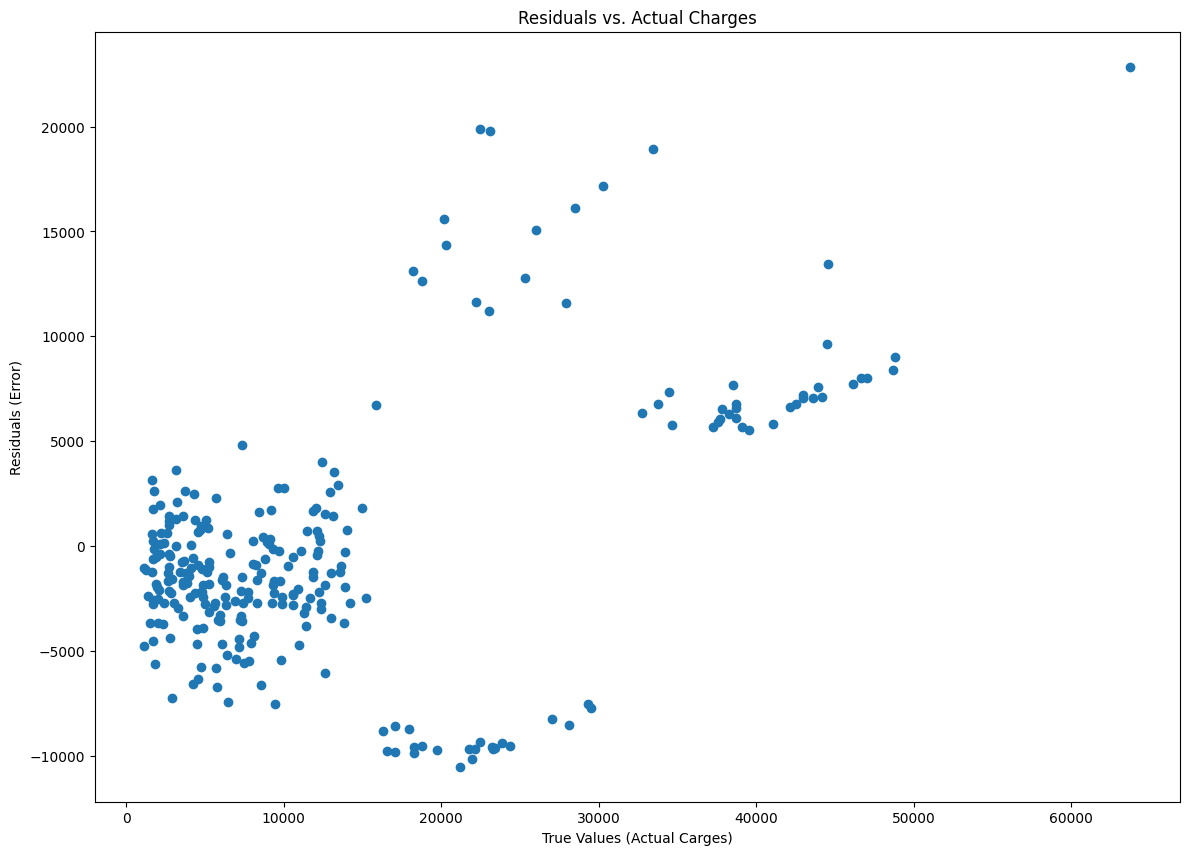

In [26]:
# Calculate the residuals
residuals = y_test - predictions

# Plot the residuals
plt.figure(figsize=(14,10))
plt.scatter(x=y_test, y=residuals)
plt.title('Residuals vs. Actual Charges')
plt.xlabel('True Values (Actual Carges)')
plt.ylabel('Residuals (Error)')
plt.show()


## Analysis

The model is quite accurate in predicting the insurance costs for charges less than 15,000, with the residuals falling within a range of +/-5000. However, for charges greater than 15,000, the model does not perform as well; the residuals can be as large as 10,000 or more, indicating that the model is over- or under-predicting the actual charge. 

The difficulty here is that the model is not able to accurately predict the outliers or extreme values. **Long-tailed distributions**, such as the one seen in this data set, can make it difficult for a model to accurately predict the extreme values.

Long-tailed distributions are distributions with a large number of data points at one end of the distribution and only a few data points at the other end. This can make it difficult for a model to accurately predict the extreme values, since there are often few samples that represent those extreme values. In addition, long-tailed distributions can lead to inaccurate predictions if the model overfits the data, as it can lead to a bias towards the more frequently occurring data points. To improve the accuracy of predictions in long-tailed distributions, it is important to use a model that can handle outliers and extreme values.

### Recommendations

To improve the model's performance, we recommend trying different features or transforming the existing features to create more predictive variables. We also recommend applying regularization techniques such as L1 or L2 regularization to reduce overfitting. We also suggest experimenting with different algorithms and using hyperparameter tuning to further improve the accuracy of the model.

We also want to check that we understand the range of issues important to management and stakeholders, and that our model is properly addressing them. If there are any additional objectives that we have not taken into account, we should make sure to include those in our model.

## Conclusion

In this project, we performed an Exploratory Data Analysis of a dataset containing information about insurance charges. We built a linear regression model to predict insurance costs and evaluated the model using R-squared, RMSE, and MAE metrics, as well as visualizing the residuals. We found that the model is quite accurate in predicting insurance costs for charges less than 15,000, but does not perform as well for higher charges. We concluded with several recommendations for improving the model's performance.

